In [1]:
import os
import re
import pandas as pd
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

In [2]:
ETF_data_file = 'NDX.csv'
date_column = 'Date'
price_column = 'Close'

hold_duration_years = 25
hold_duration_days = 252*hold_duration_years

start_date = '1985-01-01'
end_date = '9999-01-01'

In [3]:
month_mapping = {
    "Jun":6,
    "May":5,
    "Apr":4,
    "Mar":3,
    "Feb":2,
    "Jan":1,
    "Dec":12,
    "Nov":11,
    "Oct":10,
    "Sep":9,
    "Aug":8,
    "Jul":7,
    }

def date_normalize(date):
    try:
        result = re.search(r'(?P<m>\d+)\/(?P<d>\d+)\/(?P<y>\d+)', date).groupdict()
        output = '%04d-%02d-%02d'%(
            int(result['y']),
            int(result['m']),
            int(result['d']),
            )
        return output
    except:
        pass
    try:
        parsing_result = re.search(r'(?P<m>[A-z]{3}) (?P<d>\d{2}) (?P<y>\d{4})', date).groupdict()
        parsing_result['m'] = month_mapping[parsing_result['m']]
        parsing_result['m'] = '%02d'%(parsing_result['m'])
        return('%s-%s-%s'%(
            parsing_result['y'],
            parsing_result['m'],
            parsing_result['d'],
            ))
    except:
        pass
    try:
        parsing_result = re.search(r'(?P<m>[A-z]{3}) (?P<d>\d{2}), (?P<y>\d{4})', date).groupdict()
        parsing_result['m'] = month_mapping[parsing_result['m']]
        parsing_result['m'] = '%02d'%(parsing_result['m'])
        return('%s-%s-%s'%(
            parsing_result['y'],
            parsing_result['m'],
            parsing_result['d'],
            ))
    except:
        pass
    return date


date = '9/17/2015'
date = 'Jun 14 2022'
date = 'Apr 01, 1929'

date_normalize(
    date,
    )

'1929-04-01'

In [4]:
def str_to_float(input):
    try:
        return float(re.sub(r'[^\d\.]', r'', input))
    except:
        return input

In [5]:
if '.csv' in ETF_data_file.lower():
    data = pd.read_csv(
        ETF_data_file,
        )
else:
    data = pd.read_excel(
        ETF_data_file,
        )

data[date_column] = data[date_column].apply(date_normalize)
data[price_column] = data[price_column].apply(str_to_float)

data = pysqldf(u"""
    select 
    {} as date,
    {} as price
    from data
    """.format(
    date_column, 
    price_column
   ))

data = pysqldf(u"""
    select *
    from data
    where date >= '{}' and date <= '{}'
    order by date asc
    """.format(
    start_date, 
    end_date))


data['id'] = data.index

In [6]:
data.head(3)

,date,price,id
0,1985-10-01,112.139999,0
1,1985-10-02,110.824997,1
2,1985-10-03,110.870003,2


# the return

In [7]:
holding = pysqldf(u"""
    select 
    data.date,
    data.price,
    pre_data.date as pre_date,
    pre_data.price as pre_price
    from data
    join data as pre_data on pre_data.id+{} = data.id
    """.format(hold_duration_days))

In [8]:
holding.head(3)

,date,price,pre_date,pre_price
0,2015-09-25,4224.740234,1985-10-01,112.139999
1,2015-09-28,4103.470215,1985-10-02,110.824997
2,2015-09-29,4083.370117,1985-10-03,110.870003


In [9]:
window_data = pysqldf(u"""
    select boundary.*,
    window.date as window_date,
    1000.0/window.price as window_shares,
    window.price as window_price
    from holding as boundary
    join data as window
    on window.date >= boundary.pre_date and window.date < boundary.date
    """)

In [10]:
window_aggrated = pysqldf(u"""
    select date, 
    count(*)*1000.0 as invested_amount,
    sum(window_shares) as bought_shares,
    price
    from window_data 
    group by date
    """)

In [11]:
window_ratio =  pysqldf(u"""
    select *,
    bought_shares*price/invested_amount as ratio
    from window_aggrated 
    order by date asc
    """)

In [12]:
window_ratio.head(3)

,date,invested_amount,bought_shares,price,ratio
0,2015-09-25,7560000.0,14245.775671,4224.740234,7.960939
1,2015-09-28,7560000.0,14237.094948,4103.470215,7.727711
2,2015-09-29,7560000.0,14228.315409,4083.370117,7.685116
3,2015-09-30,7560000.0,14219.540732,4181.060059,7.864121
4,2015-10-01,7560000.0,14210.695191,4192.959961,7.881597
...,...,...,...,...,...
1699,2022-06-27,7560000.0,5559.826674,12008.240234,8.831182
1700,2022-06-28,7560000.0,5556.541416,11637.769531,8.553670
1701,2022-06-29,7560000.0,5553.240325,11658.259766,8.563640
1702,2022-06-30,7560000.0,5549.964135,11503.719727,8.445136


<AxesSubplot:xlabel='date'>

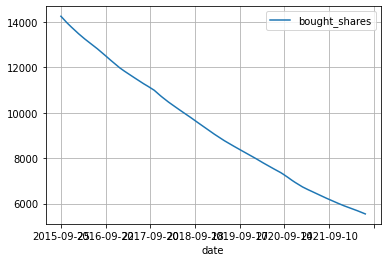

In [13]:
window_ratio.plot(x ='date', y=[
    'bought_shares', 
    ], grid = True)

<AxesSubplot:xlabel='date'>

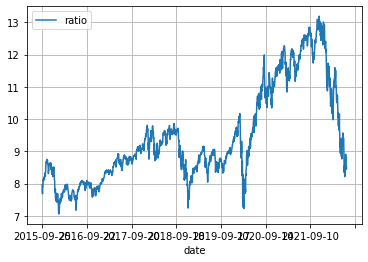

In [14]:
window_ratio.plot(x ='date', y=[
    'ratio', 
    ], grid = True)

<AxesSubplot:>

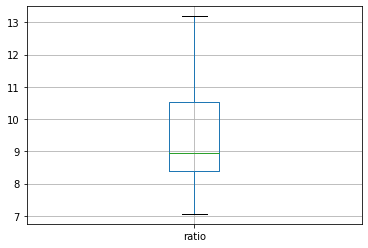

In [15]:
window_ratio.boxplot(column=['ratio']) 

In [16]:
ratio = window_ratio['ratio'].median()

print('Ratio:\t%0.4f'%(ratio))

Ratio:	8.9595


END